In [2]:
import json

from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, weekofyear, month, quarter, dayofweek, dayofmonth, dayofyear
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, to_timestamp
from pyspark.sql.types import DoubleType

# I ) - importation de données :
>> ### + La première étape consiste à importer des données à partir de l'API et à les structurer correctement.

In [32]:
import pandas as  pd
import requests
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# this code scrapes the weather APIs
url = """https://archive-api.open-meteo.com/v1/era5?latitude=52.52&longitude=13.41&start_date=2023-01-01&end_date=2023-12-31&hourly=temperature_2m"""
response = requests.get(url)
print(response)
data_json = response.json()
print(json.dumps(data_json, indent=4))
# this code structures the retrieved data in a form of DataFrame.
df_json = {}
for  item in list(data_json['hourly_units'].keys()) :
    df_json[item] = data_json['hourly'][item]
df_pandas = pd.DataFrame(df_json)  
df_pandas['time'] = pd.to_datetime(df_pandas['time'])
df_pandas    

<Response [200]>
{
    "latitude": 52.54833,
    "longitude": 13.407822,
    "generationtime_ms": 0.07605552673339844,
    "utc_offset_seconds": 0,
    "timezone": "GMT",
    "timezone_abbreviation": "GMT",
    "elevation": 38.0,
    "hourly_units": {
        "time": "iso8601",
        "temperature_2m": "\u00b0C"
    },
    "hourly": {
        "time": [
            "2023-01-01T00:00",
            "2023-01-01T01:00",
            "2023-01-01T02:00",
            "2023-01-01T03:00",
            "2023-01-01T04:00",
            "2023-01-01T05:00",
            "2023-01-01T06:00",
            "2023-01-01T07:00",
            "2023-01-01T08:00",
            "2023-01-01T09:00",
            "2023-01-01T10:00",
            "2023-01-01T11:00",
            "2023-01-01T12:00",
            "2023-01-01T13:00",
            "2023-01-01T14:00",
            "2023-01-01T15:00",
            "2023-01-01T16:00",
            "2023-01-01T17:00",
            "2023-01-01T18:00",
            "2023-01-01T19:00",
    

,time,temperature_2m
0,2023-01-01 00:00:00,15.3
1,2023-01-01 01:00:00,15.7
2,2023-01-01 02:00:00,15.8
3,2023-01-01 03:00:00,15.9
4,2023-01-01 04:00:00,15.8
...,...,...
8755,2023-12-31 19:00:00,6.3
8756,2023-12-31 20:00:00,6.7
8757,2023-12-31 21:00:00,6.1
8758,2023-12-31 22:00:00,5.2


>> ### - Ensuite, nous devons convertir les données extraites en un DataFrame Spark, afin de pouvoir les traiter librement et entraîner les modèles d'apprentissage automatique.

In [33]:
# Create a Spark session
spark = SparkSession.builder.appName("example").config("spark.executor.memory", "4g").config("spark.driver.memory", "7g").getOrCreate()
df = spark.createDataFrame(df_pandas)

# II) - exploration de données

> ## 1) - Exploreration des valeurs manquantes

In [34]:
# Check for null values in each column
for column in df.columns:
    null_count = df.where(col(column).isNull()).count()
    print(f"Null values in column '{column}': {null_count}")

Null values in column 'time': 0
Null values in column 'temperature_2m': 0


> ## 2) - visualisation de l'évolution des températures sur les 4 dernières années

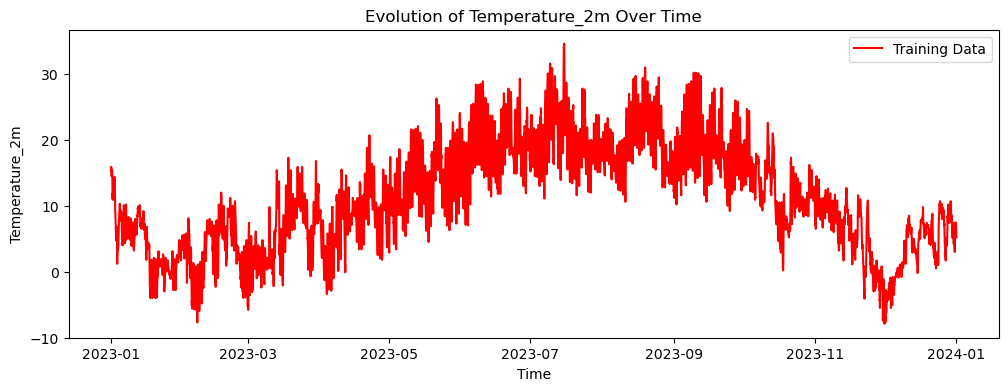

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(df.select('time').rdd.flatMap(lambda x: x).collect(), df.select('temperature_2m').rdd.flatMap(lambda x: x)
                                                                 .collect(), color='red', 
                                                                  label='Training Data')
plt.xlabel('Time')
plt.ylabel('Temperature_2m')
plt.title('Evolution of Temperature_2m Over Time')
plt.legend()
plt.show()

> ## 2) - visualisation de l'évolution des températures pour l'année en cours

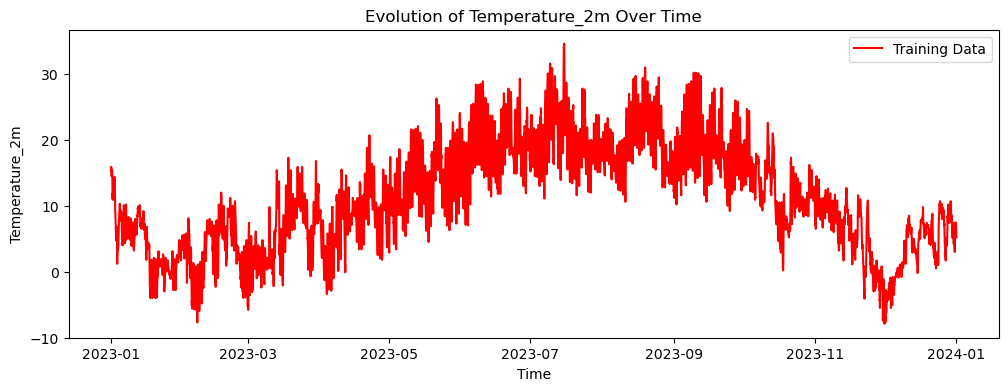

In [36]:
df = df.orderBy('time')
plt.figure(figsize=(12, 4))
plt.plot(df.select('time').rdd.flatMap(lambda x: x).collect()[-9000:], df.select('temperature_2m').rdd.flatMap(lambda x: x).collect()[-9000:], color='red', label='Training Data')
plt.xlabel('Time')
plt.ylabel('Temperature_2m')
plt.title('Evolution of Temperature_2m Over Time')
plt.legend()
plt.show()

# III) - feature Engineering : indexation chronologique
> ## 1) - maintenant, nous allons supprimer toutes les colonnes sauf « temps » et « température ».
>> - variable explicable : température.
>> - variable explicative : temps

In [37]:
# Select only the "time" and "assembled_features" columns
df = df.select("time", "temperature_2m")
df.show()

+-------------------+--------------+
|               time|temperature_2m|
+-------------------+--------------+
|2023-01-01 00:00:00|          15.3|
|2023-01-01 01:00:00|          15.7|
|2023-01-01 02:00:00|          15.8|
|2023-01-01 03:00:00|          15.9|
|2023-01-01 04:00:00|          15.8|
|2023-01-01 05:00:00|          14.6|
|2023-01-01 06:00:00|          14.5|
|2023-01-01 07:00:00|          14.5|
|2023-01-01 08:00:00|          14.6|
|2023-01-01 09:00:00|          14.7|
|2023-01-01 10:00:00|          14.9|
|2023-01-01 11:00:00|          15.1|
|2023-01-01 12:00:00|          15.4|
|2023-01-01 13:00:00|          15.2|
|2023-01-01 14:00:00|          14.8|
|2023-01-01 15:00:00|          13.5|
|2023-01-01 16:00:00|          12.5|
|2023-01-01 17:00:00|          11.0|
|2023-01-01 18:00:00|          11.3|
|2023-01-01 19:00:00|          11.9|
+-------------------+--------------+
only showing top 20 rows



> ## 2) - Si nous avons besoin de créer un modèle capable de prédire la température du futur, nous devons entraîner ce modèle sur des données ne contenant que des indices temporels. Ainsi, nous pourrons le former à cartographier la relation entre le temps et la variable cible. Pour ce faire, nous allons utiliser le script suivant.

In [38]:
data = df
df = (df
    .withColumn('hour', hour('time'))
    .withColumn('week', weekofyear('time'))
    .withColumn('month', month('time'))
    .withColumn('quarter', quarter('time'))
    .withColumn('day_of_week', dayofweek('time'))
    .withColumn('day_of_month', dayofmonth('time'))
    .withColumn('day_of_year', dayofyear('time'))
)
df.show()

+-------------------+--------------+----+----+-----+-------+-----------+------------+-----------+
|               time|temperature_2m|hour|week|month|quarter|day_of_week|day_of_month|day_of_year|
+-------------------+--------------+----+----+-----+-------+-----------+------------+-----------+
|2023-01-01 00:00:00|          15.3|   0|  52|    1|      1|          1|           1|          1|
|2023-01-01 01:00:00|          15.7|   1|  52|    1|      1|          1|           1|          1|
|2023-01-01 02:00:00|          15.8|   2|  52|    1|      1|          1|           1|          1|
|2023-01-01 03:00:00|          15.9|   3|  52|    1|      1|          1|           1|          1|
|2023-01-01 04:00:00|          15.8|   4|  52|    1|      1|          1|           1|          1|
|2023-01-01 05:00:00|          14.6|   5|  52|    1|      1|          1|           1|          1|
|2023-01-01 06:00:00|          14.5|   6|  52|    1|      1|          1|           1|          1|
|2023-01-01 07:00:00

> ## 3) -  la normalisation des  columns  :
>> #### La normalisation des données est cruciale pour garantir que toutes les caractéristiques contribuent équitablement aux modèles d'apprentissage automatique. Cela permet d'éviter que des variables avec des échelles différentes ne dominent l'apprentissage du modèle.







In [39]:
data = df 

In [40]:
# Select columns to normalize
columns_to_normalize = ['hour', 'week', 'month', 'quarter', 'day_of_week', 'day_of_month', 'day_of_year']
for col_name in columns_to_normalize:
    min_value = df.agg({col_name: 'min'}).collect()[0][0]
    max_value = df.agg({col_name: 'max'}).collect()[0][0]
    normalized_column = col_name + '_normalized'
    df = df.withColumn(normalized_column, (col(col_name) - min_value) / (max_value - min_value))
    df = df.drop(col_name).withColumnRenamed(normalized_column, col_name)

In [41]:
data.show()

+-------------------+--------------+----+----+-----+-------+-----------+------------+-----------+
|               time|temperature_2m|hour|week|month|quarter|day_of_week|day_of_month|day_of_year|
+-------------------+--------------+----+----+-----+-------+-----------+------------+-----------+
|2023-01-01 00:00:00|          15.3|   0|  52|    1|      1|          1|           1|          1|
|2023-01-01 01:00:00|          15.7|   1|  52|    1|      1|          1|           1|          1|
|2023-01-01 02:00:00|          15.8|   2|  52|    1|      1|          1|           1|          1|
|2023-01-01 03:00:00|          15.9|   3|  52|    1|      1|          1|           1|          1|
|2023-01-01 04:00:00|          15.8|   4|  52|    1|      1|          1|           1|          1|
|2023-01-01 05:00:00|          14.6|   5|  52|    1|      1|          1|           1|          1|
|2023-01-01 06:00:00|          14.5|   6|  52|    1|      1|          1|           1|          1|
|2023-01-01 07:00:00

In [42]:
data = df

# IV) - Entraînement et évaluation des modèles.
> ### Dans cette section, nous allons essayer d'Entraîner plusieurs modèles sur nos données et choisir le modèle le plus performant

In [43]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
def display_model_performance(model, test_data):
    # Make predictions on the test data
    predictions = model.transform(test_data)

    # Evaluate the model
    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)

    # Convert the PySpark DataFrame to a Pandas DataFrame
    result_df = predictions.select("label", "prediction").toPandas()

    # Plot the graph
    plt.plot(result_df['label'], result_df['prediction'], 'bo')
    plt.xlabel('Temperature')
    plt.ylabel('Prediction')
    plt.suptitle("Model Performance RMSE: %f" % rmse)
    plt.show()
    

def evaluate_model(model, test_data):
    # Make predictions on the test data
    predictions = model.transform(test_data)
    forecast_bias = predictions.agg(F.avg(predictions['label'] - predictions['prediction'])).collect()[0][0]

    # Calculate R-squared (R2)
    evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')
    r2 = evaluator.evaluate(predictions)

    # Calculate Mean Absolute Scaled Error (MASE)
    mean_absolute_error = evaluator.evaluate(predictions, {evaluator.metricName: 'mae'})
    mase = mean_absolute_error / predictions.agg(F.mean('label')).collect()[0][0]

    # Calculate Symmetric Mean Absolute Percentage Error (SMAPE)
    smape_numerator = F.sum(F.abs(predictions['label'] - predictions['prediction']))
    smape_denominator = F.sum(F.abs(predictions['label']) + F.abs(predictions['prediction']))
    smape = F.when(smape_denominator == 0, 0).otherwise(200 * smape_numerator / smape_denominator)

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = F.avg(F.abs(predictions['label'] - predictions['prediction']) / F.abs(predictions['label']))

    # Calculate Root Mean Squared Error (RMSE)
    rmse = evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'})

    # Calculate Mean Squared Error (MSE)
    mse = evaluator.evaluate(predictions, {evaluator.metricName: 'mse'})

    # Calculate Mean Absolute Error (MAE)
    mae = evaluator.evaluate(predictions, {evaluator.metricName: 'mae'})

    # Print the metrics
    print(f"Forecast Bias: {forecast_bias}")
    print(f"R-squared (R2): {r2}")
    print(f"Mean Absolute Scaled Error (MASE): {mase}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    return [ forecast_bias , r2 , mase , rmse , mse , mae ]
#  [ 'Forecast Bias' , 'R-squared (R2)' , 'Mean Absolute Scaled Error (MASE)' , 'Root Mean Squared Error (RMSE)','Mean Squared Error (MSE)' , 'Mean Absolute Error (MAE)']


In [44]:
data = df 
df = df.drop('time')

In [45]:
from pyspark.ml.feature import VectorAssembler
feature_list = []
df = df.withColumnRenamed("temperature_2m", "label")
for col in df.columns:
    if col == 'temperature_2m':
        continue
    else:
        feature_list.append(col)
assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

In [46]:
# Sort the data based on 'time'
df = df.orderBy('time')

> ## 1) - Construction et entrainement du modèle Random Forest Regressor.

>>> ### a) Construction du model 

In [47]:
rf = RandomForestRegressor(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[assembler, rf])

In [48]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

In [49]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

In [60]:
from pyspark.sql.functions import col, to_timestamp

df = data.withColumnRenamed('temperature_2m', 'label')
df = df.withColumn("time", to_timestamp("time"))
trainingData = df.filter(col('time') < '2023-10-01 12:00:00').drop('time')
testData = df.filter(col('time') >= '2023-10-01 12:00:00').drop('time')
testData.show(10)

+-----+------------------+------------------+------------------+-------+-----------+------------+-----------+
|label|              hour|              week|             month|quarter|day_of_week|day_of_month|day_of_year|
+-----+------------------+------------------+------------------+-------+-----------+------------+-----------+
| 19.9|0.5217391304347826|0.7450980392156863|0.8181818181818182|    1.0|        0.0|         0.0|       0.75|
| 20.0|0.5652173913043478|0.7450980392156863|0.8181818181818182|    1.0|        0.0|         0.0|       0.75|
| 19.2|0.6086956521739131|0.7450980392156863|0.8181818181818182|    1.0|        0.0|         0.0|       0.75|
| 18.8|0.6521739130434783|0.7450980392156863|0.8181818181818182|    1.0|        0.0|         0.0|       0.75|
| 18.0|0.6956521739130435|0.7450980392156863|0.8181818181818182|    1.0|        0.0|         0.0|       0.75|
| 16.2|0.7391304347826086|0.7450980392156863|0.8181818181818182|    1.0|        0.0|         0.0|       0.75|
| 16.0| 0.

In [62]:
trainingData = trainingData.withColumn("label", trainingData["label"].cast(DoubleType()))
testData = testData.withColumn("label", testData["label"].cast(DoubleType()))

In [88]:
trainingData

DataFrame[label: double, hour: double, week: double, month: double, quarter: double, day_of_week: double, day_of_month: double, day_of_year: double]

>>> ### b) Entrainement du model 

In [63]:
cvModel = crossval.fit(trainingData)

24/11/16 11:46:48 WARN DAGScheduler: Broadcasting large task binary with size 1266.6 KiB
24/11/16 11:46:51 WARN DAGScheduler: Broadcasting large task binary with size 1925.4 KiB
24/11/16 11:46:55 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/11/16 11:46:58 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/11/16 11:47:02 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/11/16 11:47:05 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/11/16 11:47:20 WARN DAGScheduler: Broadcasting large task binary with size 1266.6 KiB
24/11/16 11:47:23 WARN DAGScheduler: Broadcasting large task binary with size 1925.4 KiB
24/11/16 11:47:26 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/11/16 11:47:29 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/11/16 11:47:33 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/11/16 11:47:37 WARN DAGScheduler: Broad

>>> ### c) Prediction du model 

In [64]:
predictions = cvModel.transform(testData)
predictions

DataFrame[label: double, hour: double, week: double, month: double, quarter: double, day_of_week: double, day_of_month: double, day_of_year: double, features: vector, prediction: double]

In [65]:
testData.show(5)  # Check the first few rows of testData


+-----+------------------+------------------+------------------+-------+-----------+------------+-----------+
|label|              hour|              week|             month|quarter|day_of_week|day_of_month|day_of_year|
+-----+------------------+------------------+------------------+-------+-----------+------------+-----------+
| 19.9|0.5217391304347826|0.7450980392156863|0.8181818181818182|    1.0|        0.0|         0.0|       0.75|
| 20.0|0.5652173913043478|0.7450980392156863|0.8181818181818182|    1.0|        0.0|         0.0|       0.75|
| 19.2|0.6086956521739131|0.7450980392156863|0.8181818181818182|    1.0|        0.0|         0.0|       0.75|
| 18.8|0.6521739130434783|0.7450980392156863|0.8181818181818182|    1.0|        0.0|         0.0|       0.75|
| 18.0|0.6956521739130435|0.7450980392156863|0.8181818181818182|    1.0|        0.0|         0.0|       0.75|
+-----+------------------+------------------+------------------+-------+-----------+------------+-----------+
only showi

>>> ### d) évaluation des performances du modèle

In [66]:
models_performance = []
models_performance.append(['RandomForestRegressor']+evaluate_model(cvModel, testData))

Forecast Bias: -3.912016360945045
R-squared (R2): 0.22866672742230054
Mean Absolute Scaled Error (MASE): 0.5546955211218826
Root Mean Squared Error (RMSE): 4.964082691394334
Mean Squared Error (MSE): 24.642116967000817
Mean Absolute Error (MAE): 3.9449308926344364


>>> ### d) Analyse de l'importance des variables explicatives pour la prédiction

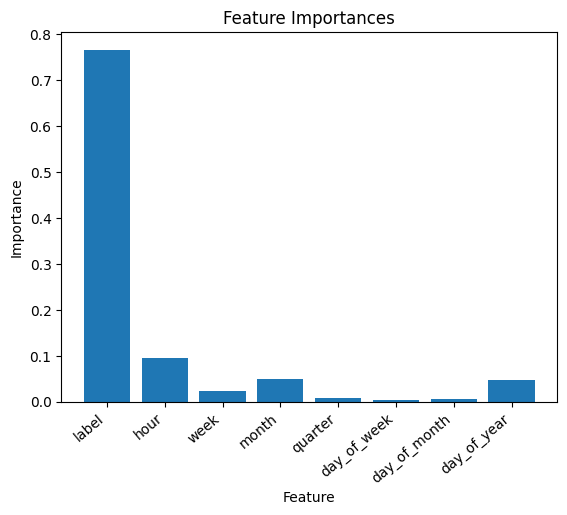

In [ ]:
display_feature_importances(cvModel)

>>> ### e) - analyse la cohérence entre la température prévue et la température réelle

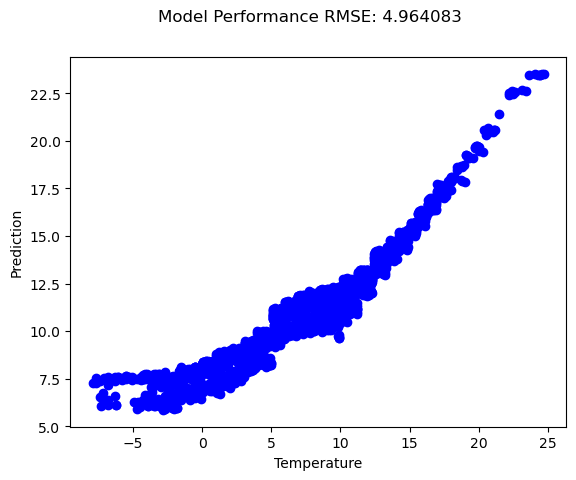

In [67]:
display_model_performance(cvModel, testData)

        Feature  Importance
0         label    0.579855
2          week    0.155889
7   day_of_year    0.115613
3         month    0.061769
4       quarter    0.050890
1          hour    0.026368
6  day_of_month    0.007178
5   day_of_week    0.002437


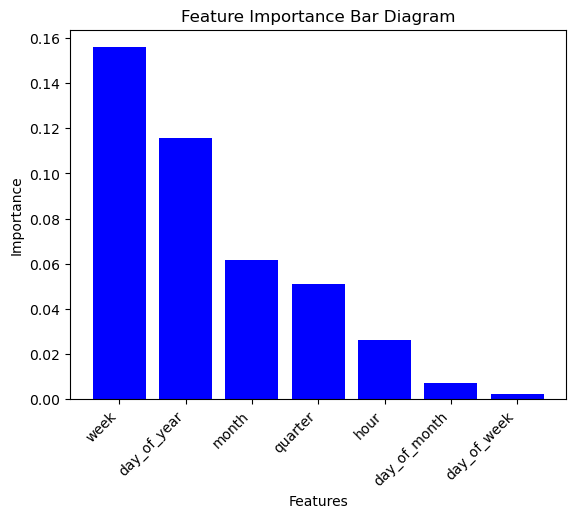

In [68]:
# Extract feature importances from the trained RandomForestRegressor model
feature_importances = cvModel.bestModel.stages[-1].featureImportances
feature_importance_df = pd.DataFrame({
    'Feature': assembler.getInputCols(),
    'Importance': feature_importances.toArray()
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

importance = list(feature_importance_df.Importance )[1:]
Feature = list(feature_importance_df.Feature )[1:]

plt.bar(Feature, importance, color='blue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Bar Diagram')
plt.xticks(rotation=45, ha='right')
plt.show()

In [70]:
# Save the model to a folder
cvModel.save("modeµls/random_forest_model")

24/11/16 12:26:31 WARN TaskSetManager: Stage 3402 contains a task of very large size (1229 KiB). The maximum recommended task size is 1000 KiB.


In [78]:
# this code scrapes the weather APIs
url = """https://archive-api.open-meteo.com/v1/era5?latitude=52.52&longitude=13.41&start_date=2024-01-01&end_date=2024-03-15&hourly=temperature_2m"""
response = requests.get(url)
print(response)
data_json = response.json()
print(json.dumps(data_json, indent=4))
# this code structures the retrieved data in a form of DataFrame.
df_json = {}
for  item in list(data_json['hourly_units'].keys()) :
    df_json[item] = data_json['hourly'][item]
df_pandas = pd.DataFrame(df_json)  
df_pandas['time'] = pd.to_datetime(df_pandas['time'])
df_pandas    

<Response [200]>
{
    "latitude": 52.54833,
    "longitude": 13.407822,
    "generationtime_ms": 0.048041343688964844,
    "utc_offset_seconds": 0,
    "timezone": "GMT",
    "timezone_abbreviation": "GMT",
    "elevation": 38.0,
    "hourly_units": {
        "time": "iso8601",
        "temperature_2m": "\u00b0C"
    },
    "hourly": {
        "time": [
            "2024-01-01T00:00",
            "2024-01-01T01:00",
            "2024-01-01T02:00",
            "2024-01-01T03:00",
            "2024-01-01T04:00",
            "2024-01-01T05:00",
            "2024-01-01T06:00",
            "2024-01-01T07:00",
            "2024-01-01T08:00",
            "2024-01-01T09:00",
            "2024-01-01T10:00",
            "2024-01-01T11:00",
            "2024-01-01T12:00",
            "2024-01-01T13:00",
            "2024-01-01T14:00",
            "2024-01-01T15:00",
            "2024-01-01T16:00",
            "2024-01-01T17:00",
            "2024-01-01T18:00",
            "2024-01-01T19:00",
   

,time,temperature_2m
0,2024-01-01 00:00:00,5.0
1,2024-01-01 01:00:00,5.4
2,2024-01-01 02:00:00,5.1
3,2024-01-01 03:00:00,4.7
4,2024-01-01 04:00:00,4.4
...,...,...
1795,2024-03-15 19:00:00,11.4
1796,2024-03-15 20:00:00,11.2
1797,2024-03-15 21:00:00,10.4
1798,2024-03-15 22:00:00,10.5


In [95]:
from pyspark.ml import PipelineModel
from pyspark.ml import Pipeline

# Try loading as a PipelineModel first
try:
    loaded_model = PipelineModel.load("models/random_forest_model/bestModel")
except Exception as e:
    print("Failed to load as PipelineModel, trying Pipeline...")
    try:
        loaded_model = Pipeline.load("models/random_forest_model/bestModel")
    except Exception as e2:
        print("Both loading methods failed.")
        print("PipelineModel error:", e)
        print("Pipeline error:", e2)
        raise e2

# Once loaded, convert your data if needed
if isinstance(df_pandas, pd.DataFrame):
    spark_df = spark.createDataFrame(df_pandas)
else:
    spark_df = df_pandas
feature_list = []
spark_df = spark_df.withColumnRenamed("temperature_2m", "label")
for col in spark_df.columns:
    if col == 'temperature_2m':
        continue
    else:
        feature_list.append(col)
df = spark_df
df = (df
    .withColumn('hour', hour('time'))
    .withColumn('week', weekofyear('time'))
    .withColumn('month', month('time'))
    .withColumn('quarter', quarter('time'))
    .withColumn('day_of_week', dayofweek('time'))
    .withColumn('day_of_month', dayofmonth('time'))
    .withColumn('day_of_year', dayofyear('time'))
)
df.show()
from pyspark.sql.functions import col, to_timestamp

columns_to_normalize = ['hour', 'week', 'month', 'quarter', 'day_of_week', 'day_of_month', 'day_of_year']
for col_name in columns_to_normalize:
    min_value = df.agg({col_name: 'min'}).collect()[0][0]
    max_value = df.agg({col_name: 'max'}).collect()[0][0]
    normalized_column = col_name + '_normalized'
    df = df.withColumn(normalized_column, (col(col_name) - min_value) / (max_value - min_value))
    df = df.drop(col_name).withColumnRenamed(normalized_column, col_name)
df = data.withColumnRenamed('temperature_2m', 'label')
df = df.withColumn("time", to_timestamp("time"))


+-------------------+-----+----+----+-----+-------+-----------+------------+-----------+
|               time|label|hour|week|month|quarter|day_of_week|day_of_month|day_of_year|
+-------------------+-----+----+----+-----+-------+-----------+------------+-----------+
|2024-01-01 00:00:00|  5.0|   0|   1|    1|      1|          2|           1|          1|
|2024-01-01 01:00:00|  5.4|   1|   1|    1|      1|          2|           1|          1|
|2024-01-01 02:00:00|  5.1|   2|   1|    1|      1|          2|           1|          1|
|2024-01-01 03:00:00|  4.7|   3|   1|    1|      1|          2|           1|          1|
|2024-01-01 04:00:00|  4.4|   4|   1|    1|      1|          2|           1|          1|
|2024-01-01 05:00:00|  3.9|   5|   1|    1|      1|          2|           1|          1|
|2024-01-01 06:00:00|  3.8|   6|   1|    1|      1|          2|           1|          1|
|2024-01-01 07:00:00|  3.5|   7|   1|    1|      1|          2|           1|          1|
|2024-01-01 08:00:00|

In [97]:
# Make predictions
predictions = loaded_model.transform(df)
predictions.show()

+-------------------+-----+--------------------+----+-----+-------+-----------+------------+-----------+--------------------+------------------+
|               time|label|                hour|week|month|quarter|day_of_week|day_of_month|day_of_year|            features|        prediction|
+-------------------+-----+--------------------+----+-----+-------+-----------+------------+-----------+--------------------+------------------+
|2023-01-01 00:00:00| 15.3|                 0.0| 1.0|  0.0|    0.0|        0.0|         0.0|        0.0|(8,[0,2],[15.3,1.0])|15.317399654049652|
|2023-01-01 01:00:00| 15.7|0.043478260869565216| 1.0|  0.0|    0.0|        0.0|         0.0|        0.0|(8,[0,1,2],[15.7,...|15.580032987382985|
|2023-01-01 02:00:00| 15.8| 0.08695652173913043| 1.0|  0.0|    0.0|        0.0|         0.0|        0.0|(8,[0,1,2],[15.8,...|15.611032987382984|
|2023-01-01 03:00:00| 15.9| 0.13043478260869565| 1.0|  0.0|    0.0|        0.0|         0.0|        0.0|(8,[0,1,2],[15.9,...|15.59

In [98]:
df.show(5)

+-------------------+-----+--------------------+----+-----+-------+-----------+------------+-----------+
|               time|label|                hour|week|month|quarter|day_of_week|day_of_month|day_of_year|
+-------------------+-----+--------------------+----+-----+-------+-----------+------------+-----------+
|2023-01-01 00:00:00| 15.3|                 0.0| 1.0|  0.0|    0.0|        0.0|         0.0|        0.0|
|2023-01-01 01:00:00| 15.7|0.043478260869565216| 1.0|  0.0|    0.0|        0.0|         0.0|        0.0|
|2023-01-01 02:00:00| 15.8| 0.08695652173913043| 1.0|  0.0|    0.0|        0.0|         0.0|        0.0|
|2023-01-01 03:00:00| 15.9| 0.13043478260869565| 1.0|  0.0|    0.0|        0.0|         0.0|        0.0|
|2023-01-01 04:00:00| 15.8| 0.17391304347826086| 1.0|  0.0|    0.0|        0.0|         0.0|        0.0|
+-------------------+-----+--------------------+----+-----+-------+-----------+------------+-----------+
only showing top 5 rows

